# Static Visualization Project

@ Jonas Zhonghan Xie

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
from tqdm import tqdm
from thefuzz import fuzz, process

symbol_list = ["†", "–", "‡"]

nyc_counties = [
    "Bronx County",
    "Kings County",
    "New York County",
    "Queens County",
    "Richmond County",
    "BRONX",
    "KINGS",
    "NEW YORK",
    "QUEENS",
    "RICHMOND",
]

In [663]:
def clean_type(x):
    if type(x) == str:
        x = x.replace(">", "").replace("<", "").replace(" ", "").replace("%", "")
    if x in symbol_list:
        return np.nan
    elif x == "2-No":
        return "0"
    elif x == "1-Yes":
        return "1"
    else:
        return x


def find_nearest(lat1, lon1, df2):
    """Find the nearest point in df2 to the point (lat1, lon1)"""
    distances = np.sqrt((df2["Latitude"] - lat1) ** 2 + (df2["Longitude"] - lon1) ** 2)
    nearest_index = distances.idxmin()
    return df2.loc[nearest_index]


def find_best_match(school_name, choices):
    """Find the best match for school_name in choices using fuzzy matching"""
    best_match, score, _ = process.extractOne(school_name, choices, scorer=fuzz.token_sort_ratio)
    return best_match, score

In [1174]:
# TO DO: Modify this code to fit the above style guide
@alt.theme.register("my_theme", enable=True) # Comment this line out for Altair 5.2


# the theme is defined as a function
def my_theme_solution():
    # you can set variables here and reuse later in the function
    font = "Noto Sans Display"

    backgroundColor = "#EBF2f6"

    font_color = "#000000"

    font_size = {
        "XL": 18,
        "L": 16,
        "M": 14,
        "S": 12,
        "XS": 10
    }
    
    diverging_palette = [
        "#006ea0",  
        "#4d9abd", 
        "#99c5d9",  
        "#ffffff", 
        "#e3c2b3",  
        "#c68466",  
        "#a03200"  
    ]

    return {
        "config": {
            "title": {
                "anchor": "start",
                "font": font,
                "fontWeight": 700,
                "fontSize": font_size["XL"],
                "subtitleFontSize": font_size["L"],
                "subtitleFont": font,
                "offset": 20
            },
            "axisX": {
                "titleFontSize": font_size["M"],
                "labelFontSize": font_size["S"],
                "grid": False,
                "labelFont": font,
           },
           "axisY": {
                "domain": False,
                "titleFontSize": font_size["M"],
                "titleAngle": 0,
                "titleBaseline": "bottom",
                "titleAnchor": "start",
                "labelFontSize": font_size["S"],
                "grid": True,
                "gridColor": "#aab0c0",
                "gridWidth": 1,
                "labelFont": font,
           },
           "axis": {
               "labelFont": font,
               "titleFont": font,
               "titleFontSize": font_size["M"],
               "labelFontSize": font_size["S"],
           },
           "background": backgroundColor,
           "view": {
               "fill": backgroundColor,
               "stroke": None,
               "padding": {"left": 5, "top": 10, "right": 5, "bottom": 10}
           },
           "range": {
                "category": ["#006EA0", "#32C0D2", "#E0B265", "#00969F", "#973C4C", "#AC8B96"],
                "ramp": ["#fef0d9", "#fdcc8a", "#fc8d59", "#e34a33", "#b30000"],
                "diverging": diverging_palette
           },
           "area": {
           },
           "line": {
           },
           "point": {
           },
           "text": {
               "fontSize": font_size["S"],
           },
           "bar": {
               "binSpacing": 1,
               "size": 25
            },
            "facet": {
                "titleFontSize": font_size["M"],
            },
            "notes": {
                "fontSize": font_size["XS"]
            },
            "sources":{
                "fontSize": font_size["XS"]
            },
       },
       "padding": {"left": 20, "top": 20, "right": 5, "bottom": 10}
    }

## Data Preparation

In [ ]:
# Prepare BEDS-DBN Crosswalk
df_lcgms = pd.read_csv("./data/lcgms_geocoded.csv", header=0, encoding="ISO-8859-1")
df_lcgms = df_lcgms[["Location Name", "ATS System Code", "Latitude", "Longitude"]]
df_lcgms.dropna(subset=["Latitude", "Longitude"], inplace=True)
df_lcgms.rename(columns={"Location Name": "School Name", "ATS System Code": "DBN"}, inplace=True)
df_lcgms["School Name"] = df_lcgms["School Name"].str.upper()
df_lcgms["Latitude"] = df_lcgms["Latitude"].astype(float)
df_lcgms["Longitude"] = df_lcgms["Longitude"].astype(float)
df_lcgms.info()

In [ ]:
df_lcgms_names = df_lcgms["School Name"].unique().tolist()

In [ ]:
df_public = pd.read_csv("data/NCES_public_clean.csv", header=0)
df_public.drop(columns=["School Name [Public School] 2015-16"], inplace=True)
df_public.columns = df_public.columns.str.replace(" [Public School] 2015-16", "")
df_public.columns

In [ ]:
df_public_location = df_public[df_public["County Name"].isin(nyc_counties)][
    ["School Name", "Latitude", "Longitude"]
]

df_public_location.dropna(subset=["Latitude", "Longitude"], inplace=True)
df_public_location["Latitude"] = df_public_location["Latitude"].apply(clean_type)
df_public_location["Longitude"] = df_public_location["Longitude"].apply(clean_type)

df_public_location["Latitude"] = df_public_location["Latitude"].astype(float)
df_public_location["Longitude"] = df_public_location["Longitude"].astype(float)

df_public_names = df_public_location["School Name"].unique()

In [ ]:
df_public_location["Best Match"], df_public_location["Score"] = zip(
    *df_public_location["School Name"].apply(lambda x: find_best_match(x, df_lcgms["School Name"]))
)
df_public_location = df_public_location[df_public_location["Score"] >= 90]

In [ ]:
df_public_location = df_public_location.merge(
    df_lcgms[["School Name", "DBN"]], left_on="Best Match", right_on="School Name", how="left"
)

In [ ]:
df_public_crosswalk = df_public_location[
    ["DBN", "School Name_x", "Latitude", "Longitude"]
].drop_duplicates()
df_public_crosswalk.rename(columns={"School Name_x": "School Name"}, inplace=True)

In [ ]:
df_public = df_public[
    [
        "School Name",
        "State Name",
        "County Name",
        "Location City",
        "Location ZIP",
        "School Type",
        "Charter School",
        "Magnet School",
        "Urban-centric Locale",
        "Title I Eligible School",
        "Total Students All Grades (Excludes AE)",
        "Free and Reduced Lunch Students",
        "American Indian/Alaska Native Students",
        "Asian or Asian/Pacific Islander Students",
        "Hispanic Students",
        "Black or African American Students",
        "White Students",
        "Nat. Hawaiian or Other Pacific Isl. Students",
        "Two or More Races Students",
        "Pupil/Teacher Ratio",
    ]
]

df_public.rename(
    columns={
        "Location City": "City",
        "Location ZIP": "ZIP",
        "Total Students All Grades (Excludes AE)": "Total Students",
        "Title I Eligible School": "Title I Eligible",
        "Free and Reduced Lunch Students": "FRL",
        "American Indian/Alaska Native Students": "American Indian/Alaska Native",
        "Asian or Asian/Pacific Islander Students": "Asian",
        "Hispanic Students": "Hispanic",
        "Black or African American Students": "Black",
        "White Students": "White",
        "Nat. Hawaiian or Other Pacific Isl. Students": "Other",
        "Two or More Races Students": "Multi-Race",
    },
    inplace=True,
)

In [ ]:
for column in df_public.columns:
    if column not in ["School Name", "State Name", "County Name", "City", "ZIP"]:
        df_public[column] = df_public[column].apply(clean_type)

for column in [
    "Charter School",
    "Magnet School",
    "Title I Eligible",
    "Total Students",
    "FRL",
    "American Indian/Alaska Native",
    "Asian",
    "Hispanic",
    "Black",
    "White",
    "Other",
    "Multi-Race",
]:
    df_public[column].fillna(0, inplace=True)
    df_public[column] = df_public[column].astype(int)

df_public["Pupil/Teacher Ratio"] = df_public["Pupil/Teacher Ratio"].apply(clean_type)
df_public["Pupil/Teacher Ratio"].fillna(0, inplace=True)
df_public["Pupil/Teacher Ratio"] = df_public["Pupil/Teacher Ratio"].astype(float)

In [ ]:
# Create percentages for FRL students and students of each race

percent_columns = [
    "FRL",
    "American Indian/Alaska Native",
    "Asian",
    "Hispanic",
    "Black",
    "White",
    "Other",
    "Multi-Race",
]

for column in percent_columns:
    new_column = "Percentage of " + column
    df_public[new_column] = df_public[column] / df_public["Total Students"] * 100

In [ ]:
df_private = pd.read_csv("data/NCES_private_clean.csv", header=0)
df_private.drop(columns=["Private School Name [Private School] 2015-16"], inplace=True)
df_private.columns = df_private.columns.str.replace(" [Private School] 2015-16", "")
df_private.columns

In [ ]:
df_private = df_private[
    [
        "Private School Name",
        "State Name",
        "County Name",
        "City",
        "ZIP",
        "Urban-centric Locale",
        "Total Students (Ungraded & PK-12)",
        "Percentage of American Indian/Alaska Native Students",
        "Percentage of Asian or Asian/Pacific Islander Students",
        "Percentage of Hispanic Students",
        "Percentage of Black Students",
        "Percentage of White Students",
        "Percentage of Nat. Hawaiian or Other Pacific Isl. Students",
        "Percentage of Two or More Races Students",
        "Pupil/Teacher Ratio",
    ]
]

df_private.rename(
    columns={
        "Private School Name": "School Name",
        "Total Students (Ungraded & PK-12)": "Total Students",
        "Percentage of American Indian/Alaska Native Students": "Percentage of American Indian/Alaska Native",
        "Percentage of Asian or Asian/Pacific Islander Students": "Percentage of Asian",
        "Percentage of Hispanic Students": "Percentage of Hispanic",
        "Percentage of Black Students": "Percentage of Black",
        "Percentage of White Students": "Percentage of White",
        "Percentage of Nat. Hawaiian or Other Pacific Isl. Students": "Percentage of Other",
        "Percentage of Two or More Races Students": "Percentage of Multi-Race",
    },
    inplace=True,
)


for column in df_private.columns:
    if column not in ["School Name", "State Name", "County Name", "City", "ZIP"]:
        df_private[column] = df_private[column].apply(clean_type)

for column in [
    "Total Students",
    "Percentage of American Indian/Alaska Native",
    "Percentage of Asian",
    "Percentage of Hispanic",
    "Percentage of Black",
    "Percentage of White",
    "Percentage of Other",
    "Percentage of Multi-Race",
]:
    df_private[column].fillna(0, inplace=True)
    if column == "Total Students":
        df_private[column] = df_private[column].astype(int)
    else:
        df_private[column] = df_private[column].astype(float)

In [ ]:
# Append to datasets
df_private["School Type"] = "Private"
df_private["Charter School"] = 0
df_private["Magnet School"] = 0
df_private["Title I Eligible"] = 0
df_private["FRL"] = 0

# append dataframes
df_schools = pd.concat([df_public, df_private], ignore_index=True)
df_schools = df_schools[df_schools["Total Students"] > 0]

In [ ]:
# Five Counties in NYC: Bronx, Kings, New York, Queens, Richmond

nyc_counties = [
    "Bronx County",
    "Kings County",
    "New York County",
    "Queens County",
    "Richmond County",
    "BRONX",
    "KINGS",
    "NEW YORK",
    "QUEENS",
    "RICHMOND",
]

df_schools_ny = df_schools[
    (df_schools["State Name"] == "NEW YORK") & (df_schools["County Name"].isin(nyc_counties))
]

In [ ]:
df_schools_ny["School Type"].value_counts()

In [ ]:
df_schools_ny.loc[df_schools_ny["School Type"] != "Private", "School Type"] = "Public"

In [ ]:
# 1856 Public School in NYC
df_schools_ny.info()

In [ ]:
df_public_ny = df_schools_ny[df_schools_ny["School Type"] == "Public"]

In [ ]:
df_public_ny = pd.merge(df_public_ny, df_public_crosswalk, on="School Name", how="left")

In [ ]:
df_scoring = pd.read_excel("./data/202324-ems-sqr-results.xlsx", sheet_name="Summary", header=0)
df_scoring = df_scoring[["DBN", "School Name", "Impact Score", "Performance Score"]]

In [ ]:
df_scoring.dropna(subset=["Impact Score", "Performance Score"], inplace=True)

In [ ]:
df_public_ny = df_public_ny.merge(df_scoring, on="DBN", how="left")

In [ ]:
df_schools_ny.to_csv("./data/cleaned_schools_ny.csv", index=False)
df_public_ny.to_csv("./data/cleaned_public_schools_ny.csv", index=False)

---

In [ ]:
df_ela = pd.read_excel(
    "./data/ny-ela-results-2013-2019-public-master.xlsx", sheet_name="All", header=0
)

df_math = pd.read_excel(
    "./data/ny-math-results-2013-2019-public-master.xlsx", sheet_name="All", header=0
)

In [ ]:
df_ela = df_ela[["DBN", "School Name", "Grade", "Year", "% Level 3+4"]]
df_ela = df_ela[df_ela["Grade"] == "All Grades"]
df_ela["% Level 3+4"] = df_ela["% Level 3+4"].apply(lambda x: float(x) if x != "s" else np.nan)
df_ela["ELA Proficient"] = df_ela["% Level 3+4"]

# transform the data into wide format, save the school name
df_ela_wide = df_ela.pivot_table(
    index=["School Name", "DBN"], columns="Year", values="ELA Proficient"
).reset_index()

df_ela_wide.columns = df_ela_wide.columns[0:2].to_list() + [
    str(i) + " ELA Proficient" for i in df_ela_wide.columns[2:]
]

In [ ]:
df_math = df_math[["DBN", "School Name", "Grade", "Year", "% Level 3+4"]]
df_math = df_math[df_math["Grade"] == "All Grades"]
df_math["% Level 3+4"] = df_math["% Level 3+4"].apply(lambda x: float(x) if x != "s" else np.nan)
df_math["Math Proficient"] = df_math["% Level 3+4"]

# transform the data into wide format, save the school name
df_math_wide = df_math.pivot_table(
    index=["School Name", "DBN"], columns="Year", values="Math Proficient"
).reset_index()

df_math_wide.columns = df_math_wide.columns[0:2].to_list() + [
    str(i) + " Math Proficient" for i in df_math_wide.columns[2:]
]

In [ ]:
df_all_test_long = pd.merge(
    df_ela[["DBN", "School Name", "Year", "ELA Proficient"]],
    df_math[["DBN", "School Name", "Year", "Math Proficient"]],
    on=["DBN", "School Name", "Year"],
    how="inner",
)

In [ ]:
df_public_ny_test = pd.merge(df_public_ny, df_all_test_long, on=["DBN"], how="left")

In [ ]:
# Tabulate the na rate in ELA proficient and Math proficient by year -> 16.8%
na_rate = (
    df_public_ny_test[df_public_ny_test["Year"].isnull()].size
    / df_public_ny_test["School Name_x"].unique().size
)
na_rate

In [ ]:
df_public_final = df_public_ny_test[df_public_ny_test["Year"].notnull()]

In [ ]:
df_public_final.loc[df_public_final["Percentage of White"] <= 20, "Segregated School"] = 1
df_public_final.loc[df_public_final["Percentage of White"] > 20, "Segregated School"] = 0

In [ ]:
segregate_stats = df_public_final.groupby(["Segregated School"]).agg(
    {
        "School Name_x": "count",
        "Title I Eligible": "mean",
        "Percentage of FRL": "mean",
        "ELA Proficient": "mean",
        "Math Proficient": "mean",
        "Impact Score": "mean",
        "Performance Score": "mean",
    }
)

segregate_stats

In [ ]:
title1_stats = df_public_final.groupby("Title I Eligible").agg(
    {
        "Percentage of White": ["mean"],
        "ELA Proficient": ["mean"],
        "Math Proficient": ["mean"],
        "Pupil/Teacher Ratio": ["mean"],
        "Impact Score": "mean",
        "Performance Score": "mean",
    }
)

title1_stats

---

In [ ]:
df_ela_race = pd.read_excel(
    "./data/ny-ela-results-2013-2019-public-master.xlsx", sheet_name="Ethnicity", header=0
)

df_math_race = pd.read_excel(
    "./data/ny-math-results-2013-2019-public-master.xlsx", sheet_name="Ethnicity", header=0
)

In [1009]:
df_ela_race_cleaned = df_ela_race[
    ["DBN", "School Name", "Grade", "Category", "Year","Mean Scale Score", "% Level 3+4"]
]
df_ela_race_cleaned = df_ela_race_cleaned[
    (df_ela_race_cleaned["Grade"] == "All Grades") & (df_ela_race_cleaned["Year"] == 2019)
]
df_ela_race_cleaned["% Level 3+4"] = df_ela_race_cleaned["% Level 3+4"].apply(
    lambda x: float(x) if x != "s" else np.nan
)

df_ela_race_cleaned["Mean Scale Score"] = df_ela_race_cleaned["Mean Scale Score"].apply(
    lambda x: float(x) if x != "s" else np.nan
)

df_ela_race_cleaned["ELA Proficient"] = df_ela_race_cleaned["% Level 3+4"]
df_ela_race_cleaned.rename(columns={"Mean Scale Score": "ELA Mean Scale Score"}, inplace=True)

df_ela_race_wide = df_ela_race_cleaned.pivot_table(
    index=["School Name", "DBN"], columns="Category", values=["ELA Proficient"]
).reset_index()


df_ela_race_wide.columns = [i[1] if i[1] != "" else i[0] for i in df_ela_race_wide.columns.to_list()]
df_ela_race_wide.columns = df_ela_race.columns[0:2].to_list() + [
    i + " ELA Proficient" for i in df_ela_race_wide.columns[2:]
]

In [1018]:
df_ela_race_long_cleaned = df_ela_race[
    ["DBN", "School Name", "Grade", "Category", "Year","Mean Scale Score", "% Level 3+4"]
]
df_ela_race_long_cleaned = df_ela_race_long_cleaned[df_ela_race_long_cleaned["Grade"] == "All Grades"]
df_ela_race_long_cleaned["% Level 3+4"] = df_ela_race_long_cleaned["% Level 3+4"].apply(
    lambda x: float(x) if x != "s" else np.nan
)

df_ela_race_long_cleaned["Mean Scale Score"] = df_ela_race_long_cleaned["Mean Scale Score"].apply(
    lambda x: float(x) if x != "s" else np.nan
)

df_ela_race_long_cleaned["ELA Proficient"] = df_ela_race_long_cleaned["% Level 3+4"]
df_ela_race_long_cleaned.rename(columns={"Mean Scale Score": "ELA Mean Scale Score"}, inplace=True)

In [1013]:
df_math_race_cleaned = df_math_race[
    ["DBN", "School Name", "Grade", "Category", "Year", "Mean Scale Score", "% Level 3+4"]
]
df_math_race_cleaned = df_math_race_cleaned[
    (df_math_race_cleaned["Grade"] == "All Grades") & (df_math_race_cleaned["Year"] == 2019)
]
df_math_race_cleaned["% Level 3+4"] = df_math_race_cleaned["% Level 3+4"].apply(
    lambda x: float(x) if x != "s" else np.nan
)
df_math_race_cleaned["Math Proficient"] = df_math_race_cleaned["% Level 3+4"]

df_math_race_cleaned['Mean Scale Score'] = df_math_race_cleaned['Mean Scale Score'].apply(
    lambda x: float(x) if x != "s" else np.nan
)

df_math_race_cleaned.rename(columns={"Mean Scale Score": "Math Mean Scale Score"}, inplace=True)

df_math_race_wide = df_math_race_cleaned.pivot_table(
    index=["School Name", "DBN"], columns="Category", values=["Math Proficient"]
).reset_index()

df_math_race_wide.columns = [i[1] if i[1] != "" else i[0] for i in df_math_race_wide.columns.to_list()]

df_math_race_wide.columns = df_math_race_wide.columns[0:2].to_list() + [
    i + " Math Proficient" for i in df_math_race_wide.columns[2:]
]

In [1023]:
df_math_race_long_cleaned = df_math_race[
    ["DBN", "School Name", "Grade", "Category", "Year","Mean Scale Score", "% Level 3+4"]
]
df_math_race_long_cleaned = df_math_race_long_cleaned[df_math_race_long_cleaned["Grade"] == "All Grades"]
df_math_race_long_cleaned["% Level 3+4"] = df_math_race_long_cleaned["% Level 3+4"].apply(
    lambda x: float(x) if x != "s" else np.nan
)

df_math_race_long_cleaned["Mean Scale Score"] = df_math_race_long_cleaned["Mean Scale Score"].apply(
    lambda x: float(x) if x != "s" else np.nan
)

df_math_race_long_cleaned["Math Proficient"] = df_math_race_long_cleaned["% Level 3+4"]
df_math_race_long_cleaned.rename(columns={"Mean Scale Score": "Math Mean Scale Score"}, inplace=True)

In [1024]:
df_race_long = pd.merge(df_ela_race_long_cleaned, df_math_race_long_cleaned, on=["DBN", "School Name", "Category", "Year"], how="inner")

In [1025]:
df_race_scores_long = df_race_long.groupby(["Category", "Year"]).agg(
    {
        "ELA Proficient": "mean",
        "Math Proficient": "mean",
        "ELA Mean Scale Score": "mean",
        "Math Mean Scale Score": "mean",
    }
).reset_index()
df_race_scores_long

ELA Proficient  Math Proficient  ELA Mean Scale Score  \
Category Year                                                          
Asian    2013       48.299968        58.708729            314.220246   
         2014       48.851281        62.998097            313.164502   
         2015       51.591529        64.403630            315.462671   
         2016       58.114277        64.143370            320.346045   
         2017       59.962327        65.217514            321.950837   
         2018       65.209771        68.821725            609.290276   
         2019       65.363575        70.594720            608.522688   
Black    2013       20.324056        19.673050            292.470240   
         2014       22.477037        24.373424            292.803152   
         2015       23.506952        24.637943            293.470788   
         2016       31.666680        24.984432            300.369485   
         2017       33.053374        25.283483            301.185396   
         2018       38.722020        30.659709            597.667663   
         2019       39.889634        33.427519            596.897553   
Hispanic 2013       20.504594        22.273465            291.948418   
         2014       22.401065        27.165210            292.034692   
         2015       23.842180        27.592883            293.013466   
         2016       31.376307        28.039387            299.924622   
         2017       33.610343        29.015907            301.189938   
         2018       39.801252        34.407437            597.832028   
         2019       40.632977        37.059005            597.015090   
White    2013       41.582713        43.934211            308.468168   
         2014       43.071554        49.565872            308.212808   
         2015       44.797345        50.589424            309.349715   
         2016       52.347063        51.964028            315.135688   
         2017       53.520269        52.246879            316.150522   
         2018       58.715697        57.209148            606.281841   
         2019       58.799208        59.559106            605.224996   

               Math Mean Scale Score  
Category Year                         
Asian    2013             322.704007  
         2014             326.403147  
         2015             327.647940  
         2016             327.650001  
         2017             327.935710  
         2018             611.284809  
         2019             612.114842  
Black    2013             290.313884  
         2014             293.043691  
         2015             292.900560  
         2016             292.335499  
         2017             291.371515  
         2018             593.600367  
         2019             594.533647  
Hispanic 2013             292.368433  
         2014             295.156310  
         2015             295.045718  
         2016             294.999740  
         2017             294.775651  
         2018             595.072629  
         2019             595.944875  
White    2013             310.246909  
         2014             314.091086  
         2015             314.981540  
         2016             315.624803  
         2017             315.445458  
         2018             605.395938  
         2019             605.782819

In [ ]:
# Plot the line chart of the proficiency rate by race and year
plt.figure(figsize=(10, 6))
plt.

In [1015]:
df_race_wide = pd.merge(df_ela_race_wide, df_math_race_wide, on=["DBN"], how="inner")

In [647]:
df_public_final = pd.merge(
    df_public_final,
    df_race_wide.loc[:, ~df_race_wide.columns.isin(["Unnamed: 0", "School Name"])],
    on="DBN",
    how="left",
)

In [649]:
# Proficiency Rate by Race
df_race_wide.agg(
    {
        "Black ELA Proficient": "mean",
        "Hispanic ELA Proficient": "mean",
        "White ELA Proficient": "mean",
        "Black Math Proficient": "mean",
        "Hispanic Math Proficient": "mean",
        "White Math Proficient": "mean",
    }
)

Black ELA Proficient        39.872789
Hispanic ELA Proficient     40.632977
White ELA Proficient        58.799208
Black Math Proficient       33.450954
Hispanic Math Proficient    37.092903
White Math Proficient       59.559106
dtype: float64

### Ethnicity Diversity by Performance Quartile
[NYC School Quality Report](https://infohub.nyced.org/reports/students-and-schools/school-quality/school-quality-reports-and-resources)

In [651]:
df_scoring = pd.read_excel("./data/202324-ems-sqr-results.xlsx", sheet_name="Summary", header=0)
df_scoring.columns.to_list()

['DBN',
 'School Name',
 'School Type',
 'Enrollment',
 'Impact Score',
 'Performance Score',
 'Instruction and Performance - Rating',
 'Safety and School Climate - Rating',
 'Relationships with Families - Rating',
 'Instruction/Learning Environment - School Percent Positive',
 'Advising and Planning - School Percent Positive',
 'Safety - School Percent Positive',
 'School Leadership - School Percent Positive',
 'Student Support - School Percent Positive',
 'Teaching Environment - School Percent Positive',
 'Communication - School Percent Positive',
 'Family Involvement - School Percent Positive',
 'Family-School Trust - School Percent Positive',
 'Average Incoming ELA Proficiency (Based on 5th Grade)',
 'Average Incoming Math Proficiency (Based on 5th Grade)',
 'Percent Female',
 'Percent Male',
 'Percent Neither Female nor Male',
 'Percent English Language Learners',
 'Percent Students with IEPs',
 'Percentage of students recommended for general ed settings with Special Ed Teacher Su

In [653]:
df_scoring_cleaned = df_scoring[
    [
        "DBN",
        "School Name",
        "Impact Score",
        "Performance Score",
        "Student Percent - Asian",
        "Student Percent - Black",
        "Student Percent - Hispanic",
        "Student Percent - Native American",
        "Student Percent - Native Hawaiian or Pacific Islander",
        "Student Percent - White",
        "Percent of teachers with 3 or more years of experience",
        "Percentage of Students with >90% Attendance",
    ]
]

df_scoring_cleaned.dropna(subset=["Impact Score", "Performance Score"], inplace=True)
df_scoring_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1871 entries, 0 to 1943
Data columns (total 12 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   DBN                                                     1871 non-null   object 
 1   School Name                                             1871 non-null   object 
 2   Impact Score                                            1871 non-null   float64
 3   Performance Score                                       1871 non-null   float64
 4   Student Percent - Asian                                 1871 non-null   object 
 5   Student Percent - Black                                 1871 non-null   object 
 6   Student Percent - Hispanic                              1871 non-null   object 
 7   Student Percent - Native American                       1871 non-null   object 
 8   Student Percent - Native Hawaiian or Pacifi

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9264\1352147907.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scoring_cleaned.dropna(subset=["Impact Score", "Performance Score"], inplace=True)


In [654]:
df_scoring_cleaned.sample(5)

,DBN,School Name,Impact Score,Performance Score,Student Percent - Asian,Student Percent - Black,Student Percent - Hispanic,Student Percent - Native American,Student Percent - Native Hawaiian or Pacific Islander,Student Percent - White,Percent of teachers with 3 or more years of experience,Percentage of Students with >90% Attendance
973,29Q131,P.S. 131 Abigail Adams,0.53,0.64,0.743,0.054,0.147,0.017,0.003,0.028,0.811,0.64
323,10X086,P.S. 086 Kingsbridge Heights,0.56,0.46,0.031,0.06,0.874,0.006,0.002,0.019,0.845,0.638
472,14K050,J.H.S. 050 John D. Wells,0.67,0.73,0.021,0.212,0.634,0.008,0,0.107,0.568,0.631
1314,84X488,The Equality Charter School,0.55,0.55,0.019,0.7,0.259,0.011,0,0.000,0.845,0.773
1201,84K934,East Flatbush Ascend Charter School,0.67,0.61,0,0.881,0.064,0.018,0,0.027,0.380,0.82


In [666]:
def per_cleaner(x):
    if type(x) == str:
        x = x.replace(">", "").replace("<", "").replace(" ", "")
        if "%" not in x:
            x = x + "%"
    return clean_type(x)

In [667]:
for column in [
    "Student Percent - Asian",
    "Student Percent - Black",
    "Student Percent - Hispanic",
    "Student Percent - Native American",
    "Student Percent - Native Hawaiian or Pacific Islander",
    "Student Percent - White",
    "Percent of teachers with 3 or more years of experience",
    "Percentage of Students with >90% Attendance",
]:
    df_scoring_cleaned[column] = df_scoring_cleaned[column].apply(per_cleaner)
    df_scoring_cleaned[column] = pd.to_numeric(df_scoring_cleaned[column], errors="coerce")
    df_scoring_cleaned[column].fillna(0, inplace=True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9264\454854888.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scoring_cleaned[column] = df_scoring_cleaned[column].apply(per_cleaner)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_9264\454854888.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scoring_cleaned[column] = pd.to_numeric(df_scoring_cleaned[column], errors="coerce")
C:\Users\Administrator\AppData\Local\Temp\ipykernel_9264\454854888.py:13: FutureWarning: A value is trying to

In [670]:
df_scoring_cleaned.loc[
    df_scoring_cleaned["Student Percent - White"] <= 0.2, "Segregated School"
] = 1
df_scoring_cleaned.loc[df_scoring_cleaned["Student Percent - White"] > 0.2, "Segregated School"] = 0

In [671]:
df_scoring_cleaned.groupby(["Segregated School"]).agg(
    {
        "School Name": "count",
        "Impact Score": "mean",
        "Performance Score": "mean",
        "Percent of teachers with 3 or more years of experience": "mean",
        "Percentage of Students with >90% Attendance": "mean",
    }
)

,School Name,Impact Score,Performance Score,Percent of teachers with 3 or more years of experience,Percentage of Students with >90% Attendance
Segregated School,,,,,
0.0,290,0.538103,0.663345,0.809497,0.752962
1.0,1581,0.504851,0.484156,0.580909,0.400691


In [673]:
df_scoring_cleaned["Average Score"] = df_scoring_cleaned[
    ["Impact Score", "Performance Score"]
].mean(axis=1)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9264\4197971199.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scoring_cleaned['Average Score'] = df_scoring_cleaned[['Impact Score', 'Performance Score']].mean(axis=1)


In [674]:
# Divide the Average score into 5 groups (5 percentile groups)
df_scoring_cleaned["Score Group"] = pd.qcut(df_scoring_cleaned["Average Score"], 5, labels=False)
df_scoring_cleaned["Score Group"].value_counts()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9264\344906376.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scoring_cleaned['Score Group'] = pd.qcut(df_scoring_cleaned['Average Score'], 5, labels=False)


Score Group
0    399
2    376
3    372
4    370
1    354
Name: count, dtype: int64

In [677]:
df_scoring_cleaned["Performance Score Group"] = pd.qcut(
    df_scoring_cleaned["Performance Score"], 5, labels=False
)
df_scoring_cleaned["Performance Score Group"].value_counts()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9264\370148310.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scoring_cleaned['Performance Score Group'] = pd.qcut(df_scoring_cleaned['Performance Score'], 5, labels=False)


Performance Score Group
1    422
0    375
3    373
4    357
2    344
Name: count, dtype: int64

In [743]:
df_scoring_cleaned.groupby(["Score Group"]).agg(
    {
        "School Name": "count",
        "Impact Score": "mean",
        "Performance Score": "mean",
        "Student Percent - White": "mean",
        "Percent of teachers with 3 or more years of experience": "mean",
        "Percentage of Students with >90% Attendance": "mean",
    }
)

,School Name,Impact Score,Performance Score,Student Percent - White,Percent of teachers with 3 or more years of experience,Percentage of Students with >90% Attendance
Score Group,,,,,,
0,399,0.345288,0.299699,0.028897,0.623276,0.397845
1,354,0.438588,0.407119,0.051816,0.658751,0.466602
2,376,0.496755,0.490559,0.081699,0.621543,0.472378
3,372,0.569355,0.595753,0.110226,0.615685,0.484194
4,370,0.709757,0.778514,0.171468,0.563651,0.460003


In [752]:
scoring_by_performance = (
    df_scoring_cleaned.groupby(["Performance Score Group"])
    .agg(
        {
            "School Name": "count",
            "Impact Score": "mean",
            "Performance Score": "mean",
            "Student Percent - White": "mean",
            "Student Percent - Black": "mean",
            "Student Percent - Hispanic": "mean",
            "Percent of teachers with 3 or more years of experience": "mean",
            "Percentage of Students with >90% Attendance": "mean",
        }
    )
    .reset_index()
)

scoring_by_performance["Student Percent - Other"] = (
    1
    - scoring_by_performance["Student Percent - White"]
    - scoring_by_performance["Student Percent - Black"]
    - scoring_by_performance["Student Percent - Hispanic"]
)

scoring_by_performance["Performance Score Group"] = scoring_by_performance["Performance Score Group"].map({
    0: "Very Low",
    1: "Low",
    2: "Medium",
    3: "High",
    4: "Very High",
})

scoring_by_performance.set_index("Performance Score Group")

,School Name,Impact Score,Performance Score,Student Percent - White,Student Percent - Black,Student Percent - Hispanic,Percent of teachers with 3 or more years of experience,Percentage of Students with >90% Attendance,Student Percent - Other
Performance Score Group,,,,,,,,,
Very Low,375,0.368533,0.284720,0.025163,0.252893,0.549187,0.652741,0.427875,0.172757
Low,422,0.447607,0.408057,0.035822,0.244941,0.499566,0.620983,0.432303,0.219671
Medium,344,0.497267,0.497238,0.069858,0.238259,0.409599,0.591791,0.443145,0.282285
High,373,0.564102,0.603271,0.120544,0.184520,0.326212,0.612885,0.470319,0.368724
Very High,357,0.688123,0.792101,0.200258,0.192941,0.246552,0.599877,0.507272,0.360249


<Axes: xlabel='Performance Score Group'>

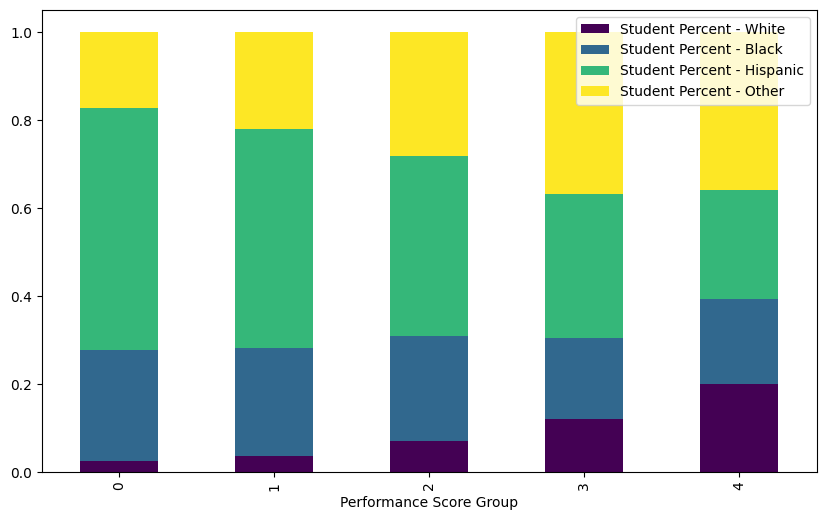

In [749]:
# Use stacked bars  to visualize the percent white, black, and hispanic students in each performance group
scoring_by_performance.set_index("Performance Score Group").plot(
    kind="bar",
    stacked=True,
    y=[
        "Student Percent - White",
        "Student Percent - Black",
        "Student Percent - Hispanic",
        "Student Percent - Other",
    ],
    figsize=(10, 6),
    colormap="viridis"
)

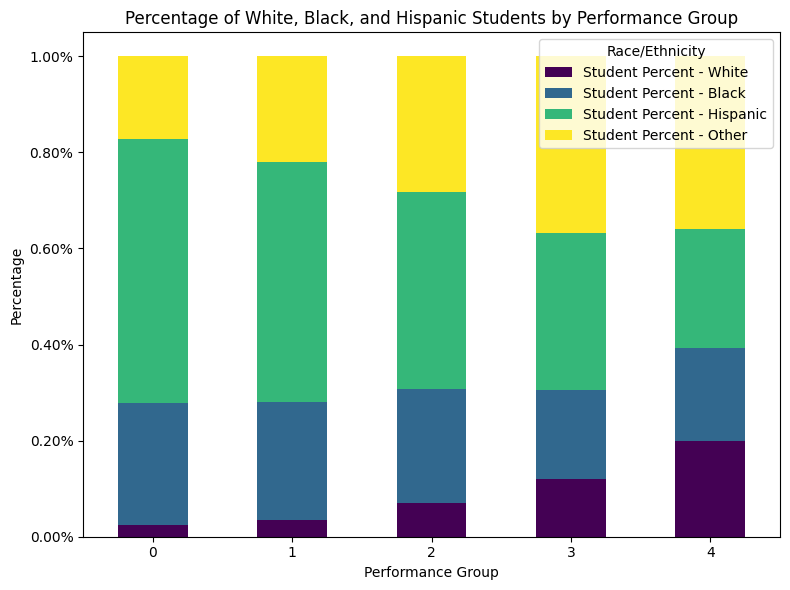

In [753]:
import matplotlib.ticker as mticker

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Stacked bar plot with percentages
scoring_by_performance.plot(
    kind="bar",
    stacked=True,
    y=[
        "Student Percent - White",
        "Student Percent - Black",
        "Student Percent - Hispanic",
        "Student Percent - Other",
    ],
    colormap="viridis",
    ax=ax,
)

# Labels and title
ax.set_ylabel("Percentage")
ax.set_xlabel("Performance Group")
ax.set_title("Percentage of White, Black, and Hispanic Students by Performance Group")
ax.legend(title="Race/Ethnicity")

# Format y-axis as percentages
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100))

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [905]:
df_long = pd.melt(
    scoring_by_performance,
    id_vars=["Performance Score Group"],
    value_vars=[
        "Student Percent - White",
        "Student Percent - Black",
        "Student Percent - Hispanic",
        "Student Percent - Other",
    ],
    var_name = "Race/Ethnicity"
)

df_long['Race/Ethnicity'] = df_long['Race/Ethnicity'].str.replace("Student Percent - ", "")
df_long['y_sort'] = df_long['Race/Ethnicity'].map({"Other": 3, "Black": 1, "Hispanic": 2, "White": 0})
df_long

,Performance Score Group,Race/Ethnicity,value,y_sort
0,Very Low,White,0.025163,0
1,Low,White,0.035822,0
2,Medium,White,0.069858,0
3,High,White,0.120544,0
4,Very High,White,0.200258,0
5,Very Low,Black,0.252893,1
6,Low,Black,0.244941,1
7,Medium,Black,0.238259,1
8,High,Black,0.184520,1
9,Very High,Black,0.192941,1


In [1175]:
x_sort = ["Very Low", "Low", "Medium", "High", "Very High"]
y_sort = [ "Black", "Hispanic", "White", "Other"]

color_scale = alt.Scale(
    domain=y_sort,
    range=[
        "rgb(0,110,160,0.7)", "rgb(50,192,210, 0.8)", "rgb(224,178,101, 0.8)", "rgb(0,150,159,0.15)"
    ],  # "Other" is 50% transparent
)
chart = (
    alt.Chart(df_long)
    .mark_bar(size=40)
    .encode(
        x=alt.X(
            "Performance Score Group:N",
            title=None,
            sort=x_sort,
            axis=alt.Axis(labelAngle=0, titlePadding=1, titleFontSize=14, labelFont="Noto Sans Display"),
        ),
        y=alt.Y(
            "value:Q",
            title=None,
            axis=alt.Axis(labelAngle=0,),
        ).stack("zero"),
        #color=alt.Color("Race/Ethnicity:N", title="Race/Ethnicity"),
        color=alt.Color("Race/Ethnicity:N", title="Race/Ethnicity", scale=color_scale),
        order=alt.Order('y_sort:O', sort='ascending'),
    )
    .properties(
        title={
            "text": "Race/Ethnicity Composition by School Performance",
            "subtitle": "Public Schools Grouped by Performance Score Quintiles",
            "subtitleFontSize": 14,
        },
        width=400,
        height=400,
    )
)

In [1182]:

# Display the chart
chart

alt.Chart(...)

In [1183]:
# Add the text annotation
text_layer = alt.Chart(df_long).mark_text(align='center', baseline='top', dy=10, font="Noto Sans Display", fontWeight=600, fontSize=13).encode(
    x=alt.X("Performance Score Group:N", sort=x_sort),
    y=alt.Y("value:Q").stack('normalize'),
    text=alt.condition(alt.datum.value >= 0.1, alt.Text("value:Q", format=".0%"), alt.value("")),
    order=alt.Order('y_sort:O', sort='ascending'),
    detail='Race/Ethnicity:N'
)


# Add a text annotation as the data source
source_text = alt.Chart(pd.DataFrame({'text': ["Source: 2024 School Quality Reports from New York City Public Schools Info Hub"]})).mark_text(
    align='left',
    baseline='top',
    color='gray',
    font= "Noto Sans Display",
    fontWeight = 400,
    fontSize=10
).encode(
    x=alt.value(-20),  # Align left
    y=alt.value(430),  # Position near bottom of chart
    text='text'
)

rule = alt.Chart().mark_rule().encode(y=alt.Y(datum=0.2))
label = rule.mark_text(
    align='center',
    baseline='bottom',
    dx=235,
    dy=5,
    fontSize=12,
    fontWeight=200,
    font="Noto Sans Display"
).encode(
    text=alt.value("Segregation")
)

# Combine the chart with the source text
final_chart = chart + text_layer + source_text + rule + label

# Display the chart
final_chart


alt.LayerChart(...)

---

### City-level Performance by Race/Ethnicity
ELA/Math Proficiency, mean scores by race/ethnicity

In [1178]:
proficiency_by_race = df_race_long.groupby(['Category']).agg({
    'ELA Proficient': lambda x: x.mean()/100,
    'Math Proficient': lambda x: x.mean()/100,
}).reset_index()

mean_scores_by_race = df_race_long.groupby(['Category']).agg({
    'ELA Mean Scale Score': 'mean',
    'Math Mean Scale Score': 'mean',
}).reset_index()

In [1179]:
proficiency_by_race.rename(columns={'ELA Proficient': 'ELA', 'Math Proficient': 'Math'}, inplace=True)
proficiency_by_race = pd.melt(proficiency_by_race, id_vars=['Category'], value_vars=['ELA', 'Math'], var_name="Subject")
proficiency_by_race

,Category,Subject,value
0,Asian,ELA,0.570410
1,Black,ELA,0.300421
2,Hispanic,ELA,0.305170
3,White,ELA,0.506706
4,Asian,Math,0.651005
5,Black,Math,0.261725
6,Hispanic,Math,0.294881
7,White,Math,0.523213


In [1187]:

proficiency_bar = alt.Chart(proficiency_by_race).mark_bar(size=34).encode(
    x=alt.X('Subject:N', axis=None),
    y=alt.Y('value:Q', title=None, axis=alt.Axis(format='.0%', grid=False)),
    color=alt.Color('Subject:N', title='Subject', scale=alt.Scale(domain=['ELA', 'Math'])),
).properties(
    width=90
)

achievement_gap_text = alt.Chart(proficiency_by_race).mark_text(
).encode(
    x=alt.X('Subject:N', axis=None),
    y=alt.Y('value:Q', title=None, axis=alt.Axis(format='.0%', grid=False)),
)

source_text = alt.Chart(pd.DataFrame({'text': ["Source: 2024 School Quality Reports from New York City Public Schools Info Hub"]})).mark_text(
    align='left',
    baseline='top',
    color='gray',
    font= "Noto Sans Display",
    fontWeight = 400,
    fontSize=10
).encode(
    x=alt.value(-20),  # Align left
    y=alt.value(430),  # Position near bottom of chart
    text='text'
)


proficiency_gap = alt.layer(proficiency_bar, achievement_gap_text).facet(
    column=alt.Column('Category:N', sort=['Black', 'Hispanic', 'White', 'Asian'], title=None),
).properties(
    title={
        "text": "Ethnicity-based Achievement Gap in NYC Public Schools",
        "fontSize": 16,
        "subtitleFontSize": 13,
        "subtitle": "Average Proficiency Rate of ELA and Math in New York State Exam",
    },
).configure_header(
    labelFontSize=12,
    labelFont="Noto Sans Display",
    labelOrient="bottom"
).configure_view(
    continuousHeight=400,
    continuousWidth=400,
    fill= "#EBF2f6"
)

proficiency_gap

alt.FacetChart(...)

In [1222]:

from altair import Padding


proficiency_bar = alt.Chart(proficiency_by_race).mark_bar(size=30).encode(
    x=alt.X('value:Q', title=None, axis=alt.Axis(format='.0%', grid=False)),
    y=alt.Y('Category:N', sort = ['Black', 'Hispanic', 'White', 'Asian']),
    color=alt.Color('Subject:N', title='Subject', scale=alt.Scale(domain=['ELA', 'Math'])),
).properties(
    height=180,
)

achievement_gap_text = alt.Chart(proficiency_by_race).mark_text(
    font="Noto Sans Display", 
    fontSize=14, 
    fontWeight=600,
    align='left',
    dx=8
).encode(
    x=alt.X('value:Q', title=None, axis=alt.Axis(format='.0%', grid=False)),
    y=alt.Y('Category:N',sort = ['Black', 'Hispanic', 'White', 'Asian'], axis=alt.Axis(grid=False, labelFont="Noto Sans Display", labelFontSize=12), title=None,),
    text=alt.Text('value:Q', format='.0%'),
    color=alt.Color('Subject:N', title='Subject', scale=alt.Scale(domain=['ELA', 'Math'], range=["#006EA0", "#E0B265"])))

source_text = alt.Chart(pd.DataFrame({'text': ["""Source: 2013-2019 School-level English Language Arts and Math State Tests from New York City Department of Education
                                               """]})).mark_text(
    align='left',
    baseline='top',
    color='gray',
    font= "Noto Sans Display",
    fontWeight = 400,
    fontSize=10
).encode(
    x=alt.value(-40),  # Align left
    y=alt.value(5),  # Position near bottom of chart
    text='text'
).properties(
    height=15
)
note_text = alt.Chart(pd.DataFrame({'text': ["""Note: Students have a score that reaches achievement level 3 in the New York State exam are considered as proficient in that subject.
                                               """]})).mark_text(
    align='left',
    baseline='top',
    color='gray',
    font= "Noto Sans Display",
    fontWeight = 400,
    fontSize=10
).encode(
    x=alt.value(-40),  # Align left
    y=alt.value(0),  # Position near bottom of chart
    text='text'
).properties(
    height=15
)
proficiency_gap = alt.layer(proficiency_bar, achievement_gap_text).facet(
    column=alt.Column('Subject:N', title=None),
)


proficiency_gap_with_source = alt.vconcat(proficiency_gap, source_text, note_text).properties(
    title={
        "text": "Ethnicity-based Achievement Gap in NYC Public Schools",
        "fontSize": 18,
        "subtitleFontSize": 14,
        "subtitle": "Average Proficiency Rate of ELA and Math in New York State Exam",
    },
    spacing=5
).configure_header(
    labelFontSize=12,
    labelFont="Noto Sans Display",
    labelOrient="bottom"
).configure_view(
    fill= "#EBF2f6",
    continuousWidth=400,
)


proficiency_gap_with_source

alt.VConcatChart(...)